In [1]:
# Imports

from pyspark.ml import Pipeline
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer,OneHotEncoder,VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import *

from pyspark.ml.classification import GBTClassifier
from pyspark.mllib.evaluation import MulticlassMetrics

import pyspark.sql.functions as F
from pyspark.ml.evaluation import BinaryClassificationEvaluator as BCE

from matplotlib import pyplot as plt
import seaborn as sns

In [22]:
# Importing our feature engineered .csv

df = spark.read.csv('gs://dataproc-staging-us-central1-881288578123-co6sg2sg/clear_csv/*.csv',header=False)
df = df.toDF('MONTH','DAY_OF_WEEK','OP_UNIQUE_CARRIER','ORIGIN','DEST','DEP_DELAY_NEW','ARR_DELAY_NEW','DISTANCE','DEP_TIME','ARR_TIME')
df = df.where(df.DISTANCE != 'DISTANCE')
df = df.withColumn("DISTANCE",col("DISTANCE").cast(IntegerType()))
df = df.withColumn("label",col("ARR_DELAY_NEW")).cast(StringType())

In [23]:
# Train test split to perform ML

train_df, test_df = df.randomSplit([0.7, 0.3], seed=42)

In [57]:
# Feature processing to make it usable for machine learning :
# We start by encoding our categorial variables to make them numerical

indexers = [StringIndexer(inputCol="MONTH", outputCol="MONTH_index").setHandleInvalid("keep"), 
           StringIndexer(inputCol="DAY_OF_WEEK", outputCol="DAY_OF_WEEK_index").setHandleInvalid("keep"), 
           StringIndexer(inputCol="OP_UNIQUE_CARRIER", outputCol="OP_UNIQUE_CARRIER_index").setHandleInvalid("keep"), 
           StringIndexer(inputCol="ORIGIN", outputCol="ORIGIN_index").setHandleInvalid("keep"),
           StringIndexer(inputCol="DEST", outputCol="DEST_index").setHandleInvalid("keep"),
           StringIndexer(inputCol="DEP_DELAY_NEW", outputCol="DEP_DELAY_NEW_index").setHandleInvalid("keep"),
           StringIndexer(inputCol="DEP_TIME", outputCol="DEP_TIME_index").setHandleInvalid("keep"),
           StringIndexer(inputCol="ARR_TIME", outputCol="ARR_TIME_index").setHandleInvalid("keep"),
           StringIndexer(inputCol="label", outputCol="label_index").setHandleInvalid("keep")
           ]

# VectorAssembler is a transformer that combines a given list of columns into a single vector column
# Spark needs our data to be formatted like this else it cant perform ML

vectorAssembler = VectorAssembler(inputCols = ["MONTH_index", "DAY_OF_WEEK_index", "OP_UNIQUE_CARRIER_index","ORIGIN_index","DEST_index","DEP_DELAY_NEW_index","DEP_TIME_index","ARR_TIME_index"],outputCol = "features")
featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4)

In [58]:
# Train a GBT model

gbt = GBTClassifier(labelCol="label_index", featuresCol="indexedFeatures", maxIter=5,maxBins=382)

In [59]:
# Pipelines makes it easier to perform all the processing on the data

stages = indexers + [vectorAssembler,featureIndexer,gbt]
pipeline = Pipeline(stages=stages)

In [60]:
# Train model and also runs the indexers

model = pipeline.fit(train_df)

# Make predictions

predictions = model.transform(test_df)

In [65]:
predictions = predictions.withColumn('label', regexp_replace('label','False','0.0'))
predictions = predictions.withColumn('label', regexp_replace('label','True','1.0'))
predictions = predictions.withColumn('label', F.col('label').cast(FloatType()))

In [66]:
# Statistics on our classifier

predictionAndLabels = predictions.select("prediction","label").rdd
multi_metrics = MulticlassMetrics(predictionAndLabels)
precision_score = multi_metrics.weightedPrecision
recall_score = multi_metrics.weightedRecall
accuracy_score = multi_metrics.accuracy
f1_score = multi_metrics.weightedFMeasure()

In [71]:
# Some metrics on our classified datas

print("Accuracy Score   : "+str(accuracy_score)) # Accuracy shows the percentage of the correct classifications with respect to all the samples
print("Precision Score  : "+str(precision_score)) # Precision is the ratio of the correctly positive labeled to all positive labeled : TP/(TP+FP)
print("Recall Score     : "+str(recall_score)) # Recall (or Sensitivity) is the ratio of the correctly positive labeled to all who are positive in reality : TP/(TP+FN)
print("F1 Score         : "+str(f1_score)) # F1-score is the harmonic mean (average) of precision and recall : 2*(Recall * Precision) / (Recall + Precision)

Accuracy Score   : 0.8089345148123178
Precision Score  : 0.8084208630596325
Recall Score     : 0.8089345148123179
F1 Score         : 0.80866539639855


In [68]:
preds_and_labels = preds_and_labels.select(['prediction','label'])
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
cf_matrix = metrics.confusionMatrix().toArray()

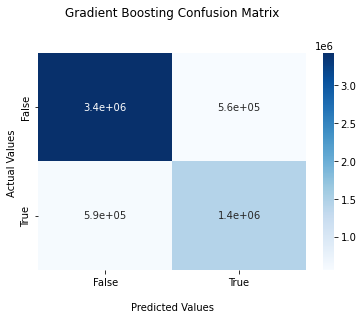

In [70]:
# Plotting the confusion matrix

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Gradient Boosting Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix

plt.show()